### Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm
import arviz as az

import sklearn
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.9/dist-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
d = pd.read_csv("data/exam.csv")

## Task 1 - Data Cleaning

In [3]:
d1 = d.drop(columns = ['id'], axis = 1)

In [4]:
# https://stackoverflow.com/questions/47139203/transpose-pandas-dataframe-and-change-the-column-headers-to-a-list
d1 = (d1.stack()
      .reset_index(level=1, name='correct')
      .rename(columns={'level_1': 'question'})[['correct', 'question']]
      .merge(d[['id']], how='inner', left_index=True, right_index=True))
# new constructed data
d1 = d1[['id', 'question', 'correct']]
# transfer both id and question as categorical variables 
d1['id'], d1['question'] = d1['id'].astype('category'), d1['question'].astype('category')
d1

,id,question,correct
0,588464,Q01,1
0,588464,Q02,1
0,588464,Q03,0
0,588464,Q04,1
0,588464,Q05,1
...,...,...,...
199,99534243,Q16,0
199,99534243,Q17,0
199,99534243,Q18,1
199,99534243,Q19,1


In [5]:
# data split
X_train, X_test = train_test_split(d1, test_size=0.2, random_state=42)

In [6]:
# separate X and y for both train and test
x_train, y_train = X_train[['id', 'question']], X_train[['correct']]
x_test, y_test = X_test[['id', 'question']], X_test[['correct']]

## Task 2 - Basic EDA

* What is the average *difficulty* of the questions in these data?

In [7]:
# first calculate the correct probability for each question using groupby, 
# then take the mean 
avg_eda = X_train.groupby('question').mean('correct').mean().values[0]
avg_eda

0.6028827050417013

To calculate the probability of getting an average question correct, at first, we calculated the probability of `correct` for each question using `groupby` function, then take the mean for these probabilities to get the average difficulty of the questions in these data, which is about 0.602883 for our training data.

* What was the hardest question based on these data?

In [8]:
# calculate the correct probability for each question using groupby
question_p = X_train.groupby('question').mean('correct')

In [9]:
# question with the lowest correct probability is the hardest question
print(question_p[question_p['correct'] == question_p['correct'].min()])
que_eda = question_p[question_p['correct'] == question_p['correct'].min()].index.item()

          correct
question         
Q14       0.12987


From the results we obtain that Q14 has the lowest correct probability value, which means that it has the lowest number of students getting it correct and it's the hardest question based on our training data, which has the correct probability 0.12987.

* Which student had the highest ability based on these data?

In [10]:
# calculate the correct probability for each student using groupby
student_p = X_train.groupby('id').mean('correct')
# student with the highest correct probability has the highest ability
print(student_p[student_p['correct'] == student_p['correct'].max()])
stu_eda = student_p[student_p['correct'] == student_p['correct'].max()].index.item()

           correct
id                
76415409  0.947368


From the results we obtain that the student with id76415409 has the highest correct probability value, which means that this student has the highest ability based on our training data, which has the correct probability 0.947368.

## Task 3 - Logistic Regression

In [11]:
# Fit the model using sklearn or statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as tsa
from patsy import dmatrices

# Fit the logistic regression model and treat the coefficient for Q1 as 0 
# to solve for nonidentification problem
log_mod = smf.glm(formula='correct~id+question+0', data=X_train, family=sm.families.Binomial()).fit()
print(log_mod.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                correct   No. Observations:                 3200
Model:                            GLM   Df Residuals:                     2981
Model Family:                Binomial   Df Model:                          218
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1503.3
Date:                Fri, 01 Apr 2022   Deviance:                       3006.6
Time:                        20:38:38   Pearson chi2:                 3.07e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3319
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
id[588464]          3.5877      0.712     

In [12]:
# store all the coefficients to a dataframe
params = pd.DataFrame({
    'coefs': log_mod.params
})
# extract all the coefficients for id column
id_params = params.loc[params.index.str.contains('id')]
# calculate the mean of coefficients for id using data 
# the actual mean here is not zero but we assume it's 0, so we need to deal with it
id_coef_mean = (np.sum(id_params[['coefs']])/200).values[0]
# extract all the coefficients for question column
que_params = params.loc[params.index.str.contains('question')].reset_index()
# reset index
que_params['question'] = que_params['index']
que_params = que_params.drop(columns = 'index')
# construct a dataframe for question1 with coefficient 0
# previously coefficient for Q1 was set to 0, we need to added it back
question1 = pd.DataFrame({
    'question': ['question[T.Q01]'],
    'coefs': [0.]
})
# append coefficient for Q1 back to the dataframe
que_params = que_params.append(question1).reset_index(drop = True)
# adjust the coefficients for questions to make the mean of coefficients for id is 0
que_params['coefs_contra'] = que_params['coefs'] + id_coef_mean

* What is the average *difficulty* of the questions in this model?

In [13]:
from scipy.special import expit
# use inverse logit function to calculate the actual difficulty 
avg_logistic = expit(np.mean(que_params['coefs_contra']))
avg_logistic

0.6622158398291278

The average difficulty we get is 0.6622158398291278, which is similar to the average difficulty we got in EDA.

* What was the hardest question based on this model?

In [14]:
# calculate the lowest correct probability for hardest question
expit(np.min(que_params['coefs_contra']))

0.08643935915228451

In [15]:
# get the hardest question 
que_logistic = que_params.iloc[np.argmin(expit(que_params['coefs_contra']))]["question"]
que_logistic

'question[T.Q14]'

Again, by applying inverse logit function on the modified coefficients we get and selecting the corresponding index of the data which generates the smallest result, we find that Q14 is the hardest question. This result coincides with the EDA result. Here the coefficient represent its relative difficulty to the reference level (Q1), so by selecting the smallest coefficient we get the hardest question.

* Which student had the highest ability based on this model?

In [16]:
# adjust the coefficients for id to make the mean as 0
id_params['coefs_contra'] = id_params['coefs'] - id_coef_mean

In [17]:
stu_logistic = id_params.index[np.argmax(expit(id_params['coefs_contra']))]
stu_logistic

'id[76415409]'

Similar to the previous question, by applying inverse logit function to the coefficients corresponding to id, we find that the student who has the highest ability is student "id[76415409]", which also coincides with the EDA's result.

## Task 4 - Mixed Effects 

When fitting a mixed effects model, we considered that in general, for each individual student and facing each different question, the baseline of the performance doesn't vary, implying the grand mean (general intercept) is fixed effect. Moreover, the effect of neither ability nor difficulty on the correctness of a task can be treated as constant and fixed, which indicates the slopes are random. Therefore, both student's ability (`id`) and question's difficulty (`question`) were treated as random effects.  

In [18]:
# Fit the model using sklearn or statsmodels
import statsmodels.genmod.bayes_mixed_glm as gbmg

fml_re = {"id": "0 + C(id)", "question": "0 + C(question)"}
mixed = gbmg.BinomialBayesMixedGLM.from_formula(formula = "correct~1", vc_formulas = fml_re, data = X_train)
mixed_fit = mixed.fit_vb()

In [19]:
que_coef_mean = mixed_fit.random_effects('question')['Mean']
id_coef_mean = mixed_fit.random_effects('id')['Mean']

Under the Binomial Bayes Mixed model, the posterior mean of the random effect of each students and questions are used as the input of the Rasch model, i.e. $\alpha_j$ and $\beta_k$, respectively. So, we used these results to answer the following questions.  

* What is the average *difficulty* of the questions in this model?

In [20]:
grand_mean = mixed_fit.params[0]

In [21]:
avg_mix = expit(grand_mean)
avg_mix

0.6471877313725284

Again, we computed the probability of correctness by plugging the posterior mean of the grand mean (the intercept) to represent the difficulty from the fitted results into the inverse logit function: $Pr({y_k}=1) = logit^{-1}(\overline{\beta_{k}})$ (since we assume that the mean for ability is 0, and the grand mean only represents difficulty).

It turns out that the average difficulty of mixed-effect model is 0.6471877376551786, which is similar to the result we got in previous "Logistic Regression" parts and the probability in task2.

* What was the hardest question based on this model?

In [22]:
print(que_coef_mean[que_coef_mean == min(que_coef_mean)])
que_mix = que_coef_mean[que_coef_mean == min(que_coef_mean)].index.values[0]

C(question)[Q14]   -2.679678
Name: Mean, dtype: float64


Question with minimum value of the posterior random effect is hardest, which is Q14. The result coincides with the previous EDA's conclusion.  

* Which student had the highest ability based on this model?

In [23]:
print(id_coef_mean[id_coef_mean == max(id_coef_mean)])
stu_mix = id_coef_mean[id_coef_mean == max(id_coef_mean)].index.values[0]

C(id)[76415409]    1.547568
Name: Mean, dtype: float64


X_train ID with maximum value of the posterior random effect shows highest ability, which is student [76415409]. The result still aligns with the what we gained in EDA part.  

## Task 5 - Bayesian Model

In [24]:
# Fit the model using pymc3`2

with pm.Model() as bayesmodel:
    
    # Hyperparameters 
    beta_mean = pm.Normal('beta_mean', 0, sd=10)
    
    # Prior
    alpha_var = pm.HalfNormal('alpha_var', sd=10)
    beta_var = pm.HalfNormal('beta_var', sd=10)
    
    # Distributions
    alpha = pm.Normal('alpha', 0, np.sqrt(alpha_var), shape=200)
    beta = pm.Normal('beta', beta_mean, np.sqrt(beta_var), shape=20)
    eta = pm.Deterministic('eta', alpha[x_train.id.cat.codes] - beta[x_train.question.cat.codes])
    # calculate alpha - beta for test data
    eta_test = pm.Deterministic('eta_test', alpha[x_test.id.cat.codes] - beta[x_test.question.cat.codes])
    
    # Likelihood
    y = pm.Bernoulli('y', logit_p=eta, observed=X_train.correct)

In [25]:
with bayesmodel:
    trace = pm.sample(return_inferencedata=True, random_seed=123)
    # predictive probability for test data
    pp = pm.sample_posterior_predictive(trace, var_names=['eta_test'], samples=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, beta_var, alpha_var, beta_mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


<Figure size 432x288 with 0 Axes>

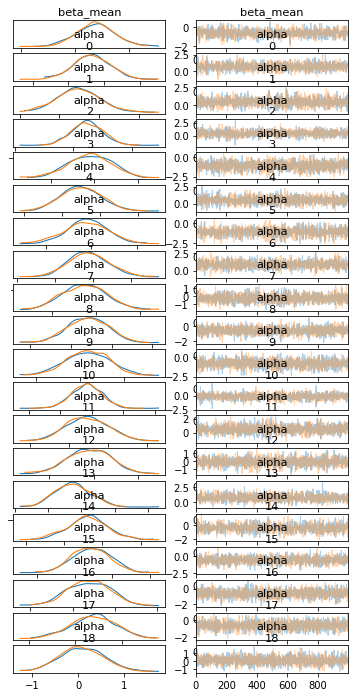

In [26]:
# model converged
plt.figure(layout='constrained')
ax = az.plot_trace(trace, compact=False, figsize=(6,12))
plt.show()

* What is the average *difficulty* of the questions in this model?

In [27]:
bayes_coefs = az.summary(trace)

In [28]:
beta_post_mean = - bayes_coefs.loc['beta_mean', 'mean']
avg_bayes = expit(beta_post_mean)
avg_bayes

0.6509005438802886

Since in Rasch model, it has the form of $\alpha - \beta$. So to get the difficulty information, we add a negative sign to the beta coefficients. The average difficulty we got is 0.6509005438802886, which is very close to previous 2 models and the probability in task1.

* What was the hardest question based on these this model?

In [29]:
beta_coefs = bayes_coefs.loc[bayes_coefs.index.str.contains('beta\[')]

In [30]:
diff_index = np.argmin(-beta_coefs['mean'])

In [31]:
expit(np.min(-beta_coefs['mean']))

0.11066169048677241

In [32]:
que_bayes = X_train.question.loc[X_train.question.cat.codes==diff_index][0]
que_bayes

'Q14'

Simply by selecting the smallest value of adjusted beta coefficient, we got the same result that Q14 is the hardest question.

* Which student had the highest ability based on these this model?

In [33]:
alpha_coefs = bayes_coefs.loc[bayes_coefs.index.str.contains('alpha\[')]
ability_index = np.argmax(alpha_coefs['mean'])

In [34]:
expit(np.max(alpha_coefs['mean']))

0.8276410036283912

In [35]:
stu_bayes = X_train.id.loc[X_train.id.cat.codes==ability_index].iloc[0]
stu_bayes

76415409

Since the sign of alpha coefficient is positive, we got the student with highest ability by selecting the id with largest alpha coefficient

## Task 6 - Comparison

- Compare results of three questions on each model
- $\alpha_j$: ability; $\beta_k$: difficulty

In [36]:
result = {'Basic EDA': [avg_eda,que_eda,stu_eda],
          'Logistic Regression':[avg_logistic,que_logistic[-4:-1],stu_logistic[-9:-1]],
          'Mixed Effects': [avg_mix, que_mix[-4:-1],stu_mix[-9:-1]],
          'Bayesian Model': [avg_bayes,que_bayes,stu_bayes]}
comparision = pd.DataFrame(result, index =['Average Difficulty','Hardest Question','Highest Ability Student'])
comparision

,Basic EDA,Logistic Regression,Mixed Effects,Bayesian Model
Average Difficulty,0.602883,0.662216,0.647188,0.650901
Hardest Question,Q14,Q14,Q14,Q14
Highest Ability Student,76415409,76415409,76415409,76415409


From the table above we see that all 4 methods produced same results on the hardest question and highest ability student. While all 3 models produced similar results on the average difficulty, the average difficulty obtained from EDA is slightly different. We assume that is because the EDA result is computed based on the whole data set while the results obtained from models are computed based on the training set.

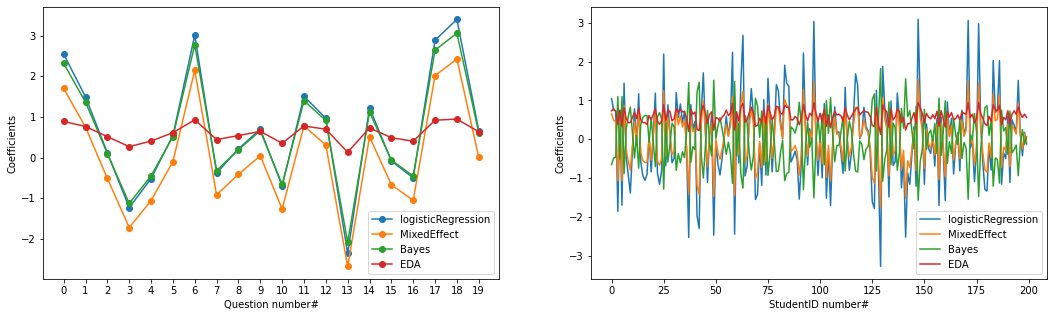

In [37]:
# plot lines show coefficients of question and id
# 1. Logistic Regression 
lgt_Qcoeff = que_params.coefs_contra
lgt_IDcoeff = id_params.coefs_contra
# (last_one is Q1,roll last row to first row)
lgt_Qcoeff = pd.Series(np.roll(lgt_Qcoeff.values,1))

# 2. Mixed Effect
mixed_Qcoef_mean = que_coef_mean
mixed_IDcoeff_mean = id_coef_mean

#3. Bayes model
nayes_Qcoeff = -beta_coefs['mean']
nayes_IDcoeff = -alpha_coefs['mean']

#4. EDA
eda_Qcoeff = X_train.groupby('question').mean('correct')
eda_IDcoeff = student_p

fig, ax = plt.subplots(1,2,figsize=(18,5))
# Draw the graph
ax[0].plot(lgt_Qcoeff.values,linestyle='-', marker='o',label='logisticRegression')
ax[0].plot(mixed_Qcoef_mean.values,linestyle='-', marker='o',label='MixedEffect')
ax[0].plot(nayes_Qcoeff.values,linestyle='-', marker='o',label='Bayes')
ax[0].plot(eda_Qcoeff.values,linestyle='-', marker='o',label='EDA')
ax[0].legend()
ax[0].set_xticks(np.arange(20))
ax[0].set_xlabel("Question number#")
ax[0].set_ylabel("Coefficients")

ax[1].plot(lgt_IDcoeff.values,linestyle='-',label='logisticRegression')
ax[1].plot(mixed_IDcoeff_mean.values,linestyle='-',label='MixedEffect')
ax[1].plot(nayes_IDcoeff.values,linestyle='-',label='Bayes')
ax[1].plot(eda_IDcoeff.values,linestyle='-',label='EDA')
ax[1].legend()
ax[1].set_xlabel("StudentID number#")
ax[1].set_ylabel("Coefficients")

plt.show()

In terms of question difficulty, we see that all 3 models produced similar results. Their trends are the same while logistic regression and Bayes model produced very close coefficients which are bigger than mixed effect model coefficients. All models' results are more variant than the EDA result, but all of them reflect the trend of EDA result.

In terms of student ability, since there are many students, the plot is kind of hard to read. Nevertheless, we can still identify that logistic regression produced more variant coefficients than other methods and all methods show similar trends.

## Task 7 - Evaluation

Three models have similar ROC curve and AUC scores.

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve

# logistic model
log_prob = log_mod.predict(x_test)
log_auc = roc_auc_score(y_test, log_prob)
fpr, tpr, thresholds = roc_curve(y_test, log_prob)

# predicted prob for mixed effect model
params = mixed_fit.random_effects()[['Mean']]
# unify the form for two dataframe
params.index = params.index.str.replace('C\([a-z]+\)\[', '', regex = True)
params.index = params.index.str.replace('\]', '', regex = True)
# change id column to string type
x_test['id'] = x_test['id'].astype('string')
# merge test data and params data together
combined = x_test.merge(params, how = 'left', right_index = True, left_on = 'id')
combined2 = combined.merge(params, how = 'left', right_index = True, left_on = 'question', suffixes=('_id', '_que'))
# calculate alpha - beta for general probability for test data
combined2['predict_p'] = expit(combined2['Mean_id'] + combined2['Mean_que'])

# mixed effect model
mixed_auc = roc_auc_score(y_test, combined2['predict_p'])
fpr2, tpr2, thresholds2 = roc_curve(y_test, combined2['predict_p'])

# bayes model
# posterior mean 
bayes_prob = pp['eta_test'].mean(axis = 0)
bayes_auc = roc_auc_score(y_test, bayes_prob)
fpr3, tpr3, thresholds3 = roc_curve(y_test, bayes_prob)

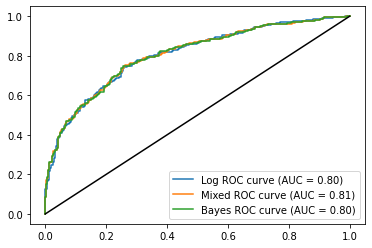

In [39]:
# logistic regression model
plt.plot(fpr, tpr, label='Log ROC curve (AUC = %0.2f)' % log_auc)
# mixed effect model
plt.plot(fpr2, tpr2, label='Mixed ROC curve (AUC = %0.2f)' % mixed_auc)
# bayes model
plt.plot(fpr3, tpr3, label='Bayes ROC curve (AUC = %0.2f)' % bayes_auc)
plt.plot([0,1], [0,1], color='black')
plt.legend(loc='lower right')